# JAX demo: Can we clone a PHOENIX stellar model spectrum?

Let's demo using JAX for blasé.

In [1]:
from gollum.phoenix import PHOENIXSpectrum
%matplotlib inline
%config InlineBackend.figure_format='retina'

`blasé` is much faster if you happen to have an NVIDIA® GPU.  Most consumer laptops don't have this hardware, but `cpu` codes will still work (just slower)!

### Set the wavelength limits

We will target a relatively narrow chunk of spectrum: $11000 - 11180$ Å.  We use a $60$ Å buffer to deal with edge effects.

In [2]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in a precomputed synthetic stellar spectrum

The [gollum](http://gollum-astro.readthedocs.io) precomputed synthetic spectral model interface makes this step pretty straightforward.  You don't even need to have the file locally-- gollum can fetch it for you.

In [3]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, 
                                   wl_lo=wl_lo, wl_hi=wl_hi, download=True)

The pristine PHOENIX spectrum needs to be flattened to facilitate line finding:  We first divide out the black body and then divide by a $5^{th}$ order polynomial.

In [4]:
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()

Bummer, gollum is broken for some reason!!

In [5]:
#stellar_spectrum.fit_continuum()

Just do it manually...

In [6]:
from specutils.fitting import fit_generic_continuum
cont_norm_spec = stellar_spectrum / fit_generic_continuum(stellar_spectrum)(stellar_spectrum.spectral_axis) 

In [7]:
stellar_spectrum = cont_norm_spec.normalize(percentile=99)

(0.0, 1.1)

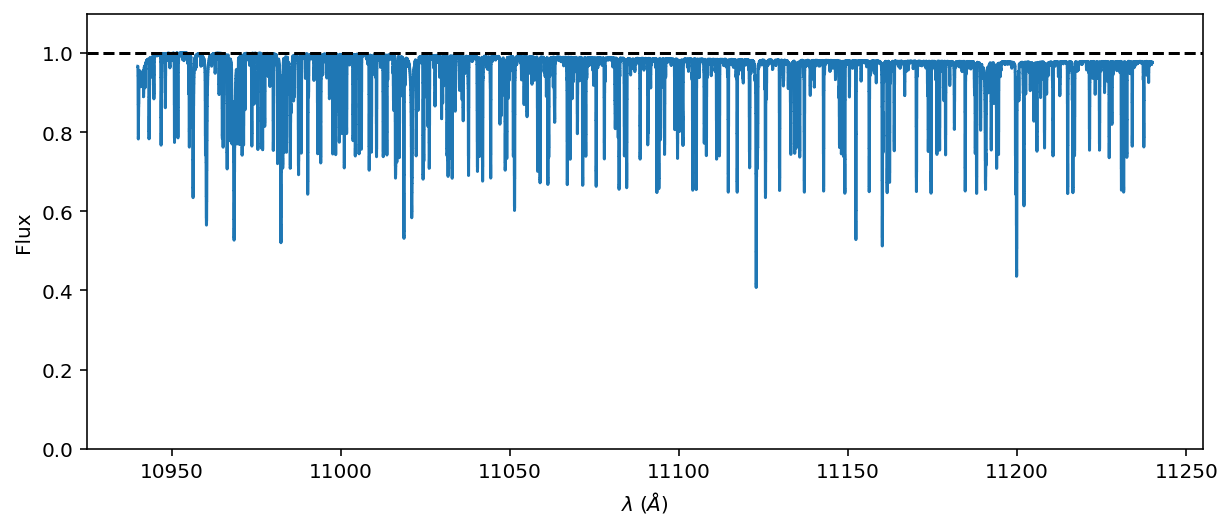

In [8]:
ax = stellar_spectrum.plot()
ax.axhline(1.0, color='k', linestyle='dashed')
ax.set_ylim(0.0,1.1)

Lame, its not a great continuum flattening.  Mine was better!!

## Clone the stellar model

We make an emulator for the spectrum by cloning all of the spectral lines above some prominence threshold:

In [9]:
import matplotlib.pyplot as plt

In [10]:
import math
import jax
import jax.numpy as jnp
import numpy as np
from scipy.signal import find_peaks, peak_prominences, peak_widths
#jax.config.update("jax_enable_x64", True)

In [11]:
flux_native = stellar_spectrum.flux.value
wl_native = stellar_spectrum.wavelength.value

In [12]:
prominence = 0.01

In [13]:
from blase.jaxemulator import SparseLinearEmulator

TypeError: function() argument 'code' must be code, not str

In [14]:
sparse_emulator = SparseLinearEmulator.init(wl_native, flux_native, prominence=prominence, wing_cut_pixels=1000)

NameError: name 'SparseLinearEmulator' is not defined

In [15]:
vec = sparse_emulator.sigma_widths

In [16]:
jnp.expand_dims(vec, 0).shape

(1, 424)

In [17]:
pred = sparse_emulator.forward(sparse_emulator.amplitudes, 
                               sparse_emulator.sigma_widths, 
                               sparse_emulator.gamma_widths)

In [18]:
target = flux_native[sparse_emulator.active_mask]
wl_active = wl_native[sparse_emulator.active_mask]

(0.0, 1.1)

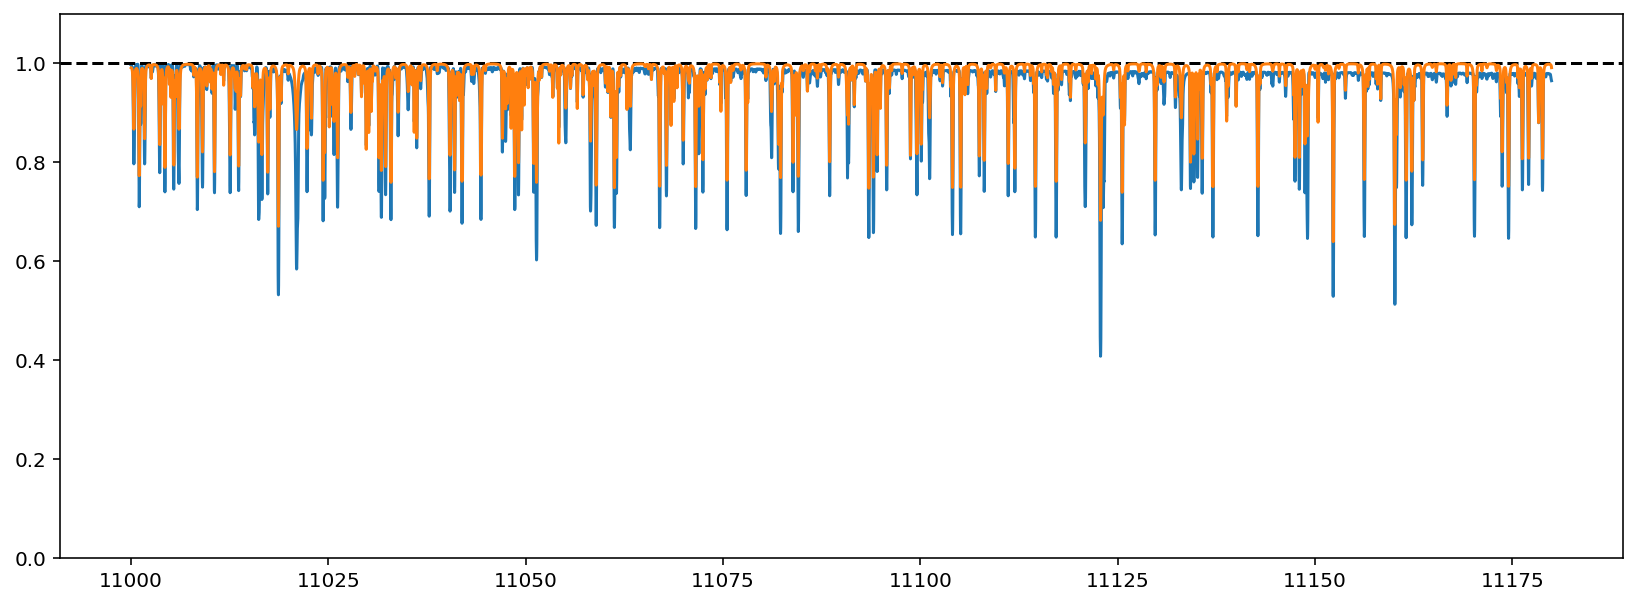

In [19]:
plt.figure(figsize=(14, 5))
plt.plot(wl_active, target)
plt.axhline(1.0, color='k', linestyle='dashed')
plt.plot(wl_native[sparse_emulator.active_mask], pred)
plt.ylim(0.0,1.1)

## Optimize

In [22]:
import optax

In [23]:
initial_params = {
    'ln_amplitudes': sparse_emulator.amplitudes,
    'ln_sigma_widths': sparse_emulator.sigma_widths,
    'ln_gamma_widths': sparse_emulator.gamma_widths,
}


def loss_mse(params: optax.Params):
    y_hat = sparse_emulator.forward(params['ln_amplitudes'], params['ln_sigma_widths'], params['ln_gamma_widths'])
    loss_value = optax.l2_loss(y_hat, target).sum()
    return loss_value

In [24]:
loss = loss_mse

In [25]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i in range(2_000):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 100 == 0:
            print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-3)
params = fit(initial_params, optimizer)

step 0, loss: 5.699609279632568
step 100, loss: 4.075206279754639
step 200, loss: 2.996842861175537
step 300, loss: 2.307459592819214
step 400, loss: 1.8595993518829346
step 500, loss: 1.5556344985961914
step 600, loss: 1.3383957147598267
step 700, loss: 1.1777417659759521
step 800, loss: 1.0567001104354858
step 900, loss: 0.9643446207046509
step 1000, loss: 0.8932323455810547
step 1100, loss: 0.8381739258766174
step 1200, loss: 0.7952165007591248
step 1300, loss: 0.7612240314483643
step 1400, loss: 0.7340134382247925
step 1500, loss: 0.711899995803833
step 1600, loss: 0.6935295462608337
step 1700, loss: 0.6783610582351685
step 1800, loss: 0.6658910512924194
step 1900, loss: 0.6555771827697754


In [25]:
post = sparse_emulator.forward(params['ln_amplitudes'], 
                               params['ln_sigma_widths'], 
                               params['ln_gamma_widths'])

(11075.0, 11100.0)

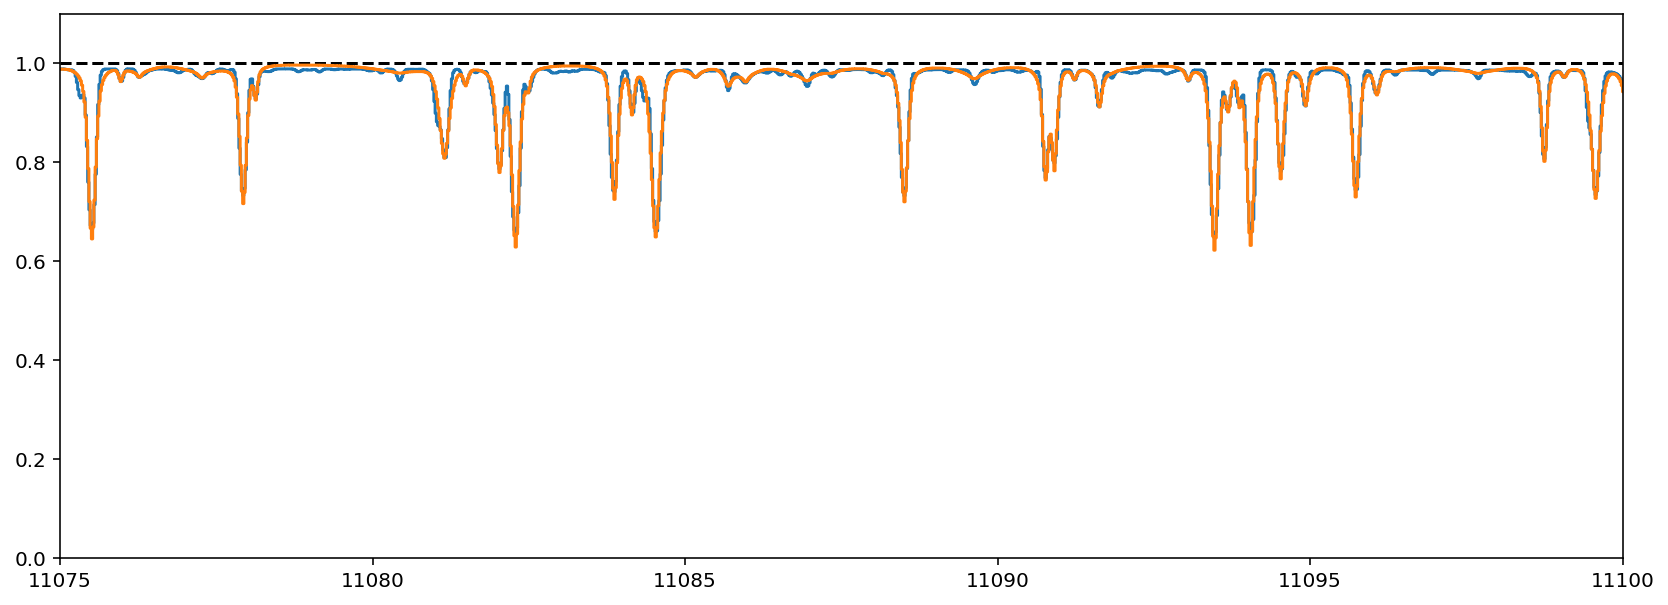

In [26]:
plt.figure(figsize=(14, 5))
plt.step(wl_active, target)
plt.axhline(1.0, color='k', linestyle='dashed')
plt.step(wl_native[sparse_emulator.active_mask], post)
plt.ylim(0.0,1.1)
plt.xlim(11_075, 11_100)

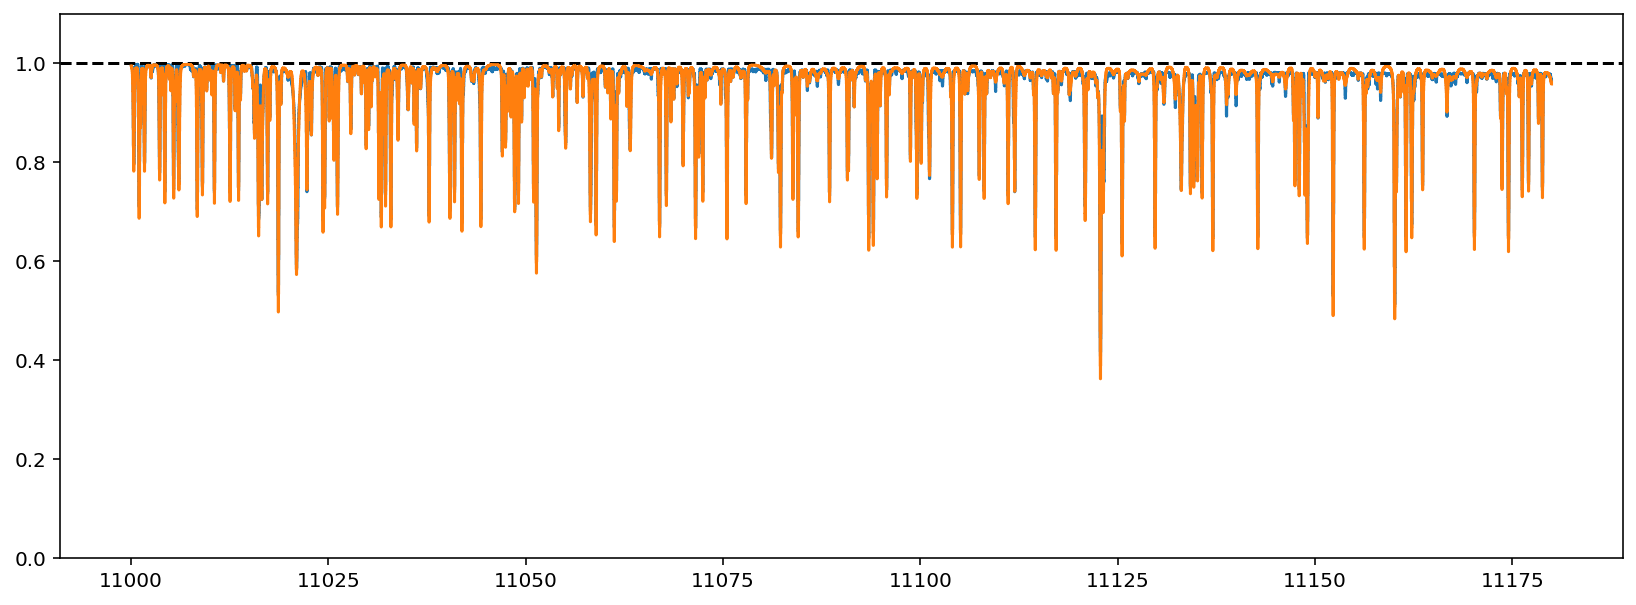

In [27]:
plt.figure(figsize=(14, 5))
plt.step(wl_active, target)
plt.axhline(1.0, color='k', linestyle='dashed')
plt.step(wl_native[sparse_emulator.active_mask], post)
plt.ylim(0.0,1.1);

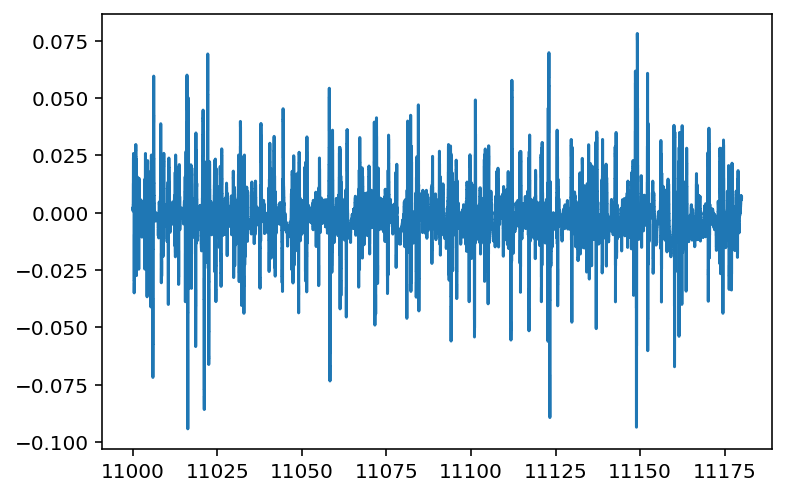

In [29]:
plt.step(wl_native[sparse_emulator.active_mask], target - post)

Notice how individual spectral lines are attempting to make up for the imperfections in the continuum by bloating their line wings.  

We don't want that!  We'll probably want to use a GP!

## Use TinyGP to fit the continuum!

In [30]:
from tinygp import kernels
from tinygp import GaussianProcess

In [31]:
kernel = kernels.ExpSquared(scale=125.5)

In [32]:
gp = GaussianProcess(0.001*kernel, wl_active, diag=1e-6)

In [33]:
%%time
draw = gp.sample(jax.random.PRNGKey(4))

CPU times: user 3.02 s, sys: 887 ms, total: 3.91 s
Wall time: 3.48 s


In [34]:
residual = target-post

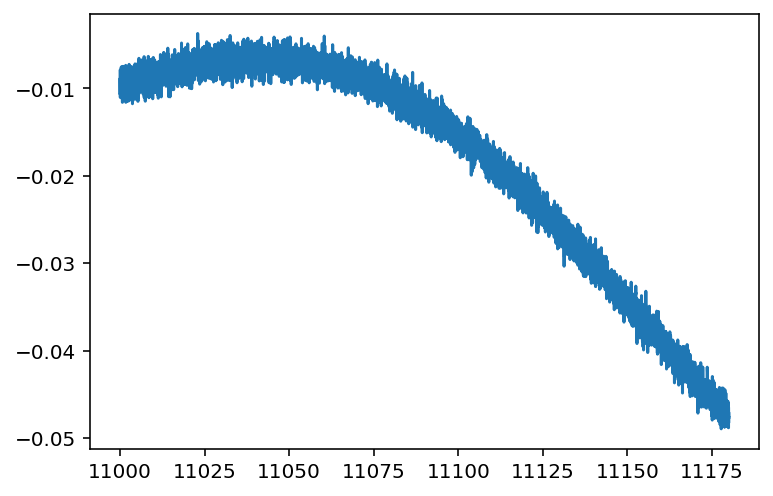

In [35]:
plt.step(wl_active, draw)

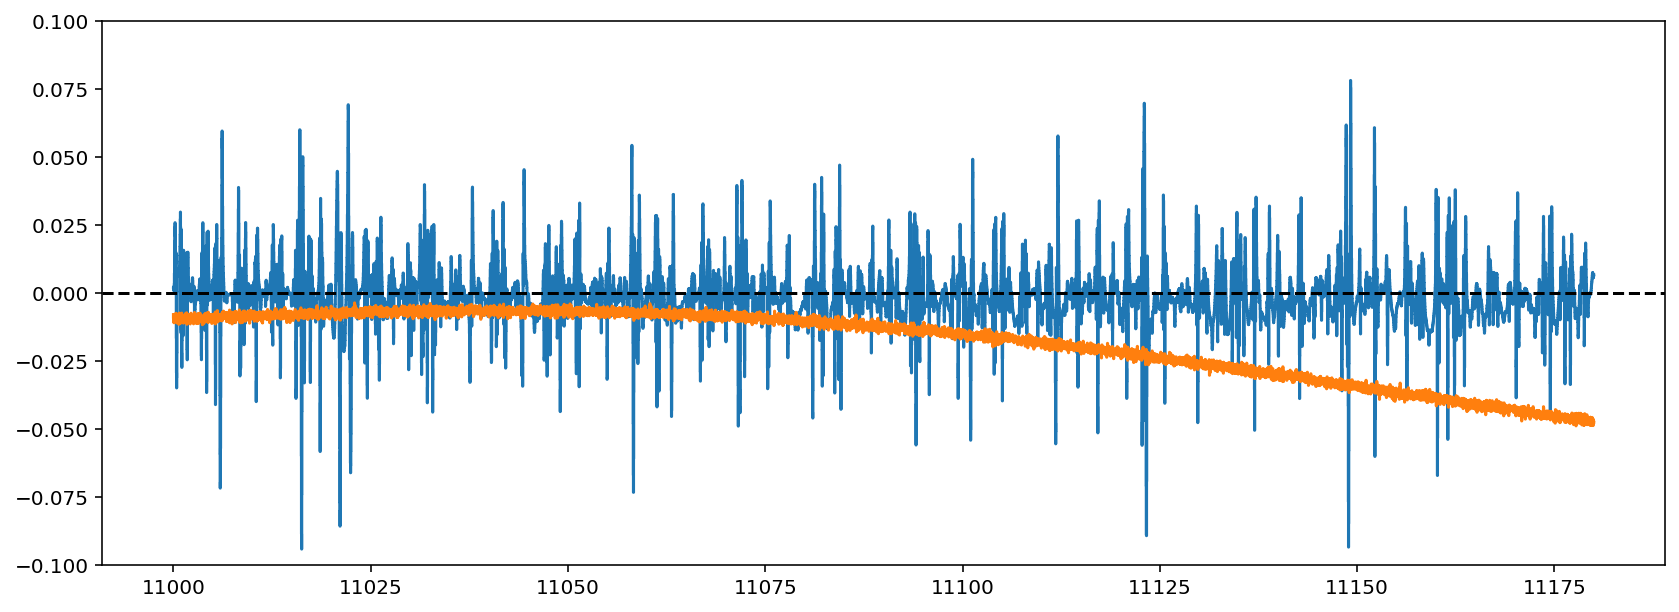

In [36]:
plt.figure(figsize=(14, 5))
plt.step(wl_active, residual)
plt.axhline(0.0, color='k', linestyle='dashed')
plt.step(wl_active, draw)
plt.ylim(-0.1,0.1);

In [38]:
def build_gp(params):
    kernel = jnp.exp(params["log_amp"]) * kernels.quasisep.Matern32(
        jnp.exp(params["log_scale"])
    )
    return GaussianProcess(kernel, wl_active, diag=jnp.exp(params["log_diag"]))


@jax.jit
def loss_gp(params, resid):
    gp = build_gp(params)
    return -gp.log_probability(resid)


params_gp = {
    "log_amp": -3.1,
    "log_scale": 4.0,
    "log_diag": -4.0,
}
loss_gp(params_gp, residual)

DeviceArray(-9651.462, dtype=float32)

Nice! This looks like it can work!  Let's tie it all together:

## Combine mean model and GP

In [39]:
def loss_total(params: optax.Params):
    y_hat = sparse_emulator.forward(params['blase']['ln_amplitudes'], 
                                    params['blase']['ln_sigma_widths'], 
                                    params['blase']['ln_gamma_widths'])
    residual = target - y_hat
    return loss_gp(params['gp'], residual)

In [42]:
params_total = {
    "blase": params,
    "gp": params_gp
}

In [41]:
loss_total(params_total)

DeviceArray(-9651.462, dtype=float32)

In [59]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss_total)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i in range(8_000):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 100 == 0:
            print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-3)
best_fit = fit(params_total, optimizer)

step 0, loss: -9651.4619140625
step 100, loss: -10101.4697265625
step 200, loss: -10550.28125
step 300, loss: -10998.1416015625
step 400, loss: -11445.1708984375
step 500, loss: -11891.23828125
step 600, loss: -12336.3994140625
step 700, loss: -12780.599609375
step 800, loss: -13223.8623046875
step 900, loss: -13665.9306640625
step 1000, loss: -14106.78125
step 1100, loss: -14546.0634765625
step 1200, loss: -14984.1552734375
step 1300, loss: -15420.3505859375
step 1400, loss: -15856.3115234375
step 1500, loss: -16288.9853515625
step 1600, loss: -16719.982421875
step 1700, loss: -17148.66796875
step 1800, loss: -17574.693359375
step 1900, loss: -17997.876953125
step 2000, loss: -18418.017578125
step 2100, loss: -18834.87109375
step 2200, loss: -19248.142578125
step 2300, loss: -19657.408203125
step 2400, loss: -20061.921875
step 2500, loss: -20462.078125
step 2600, loss: -20857.7265625
step 2700, loss: -21246.86328125
step 2800, loss: -21630.478515625
step 2900, loss: -22007.65234375
st

In [60]:
post = sparse_emulator.forward(best_fit['blase']['ln_amplitudes'], 
                               best_fit['blase']['ln_sigma_widths'], 
                               best_fit['blase']['ln_gamma_widths'])

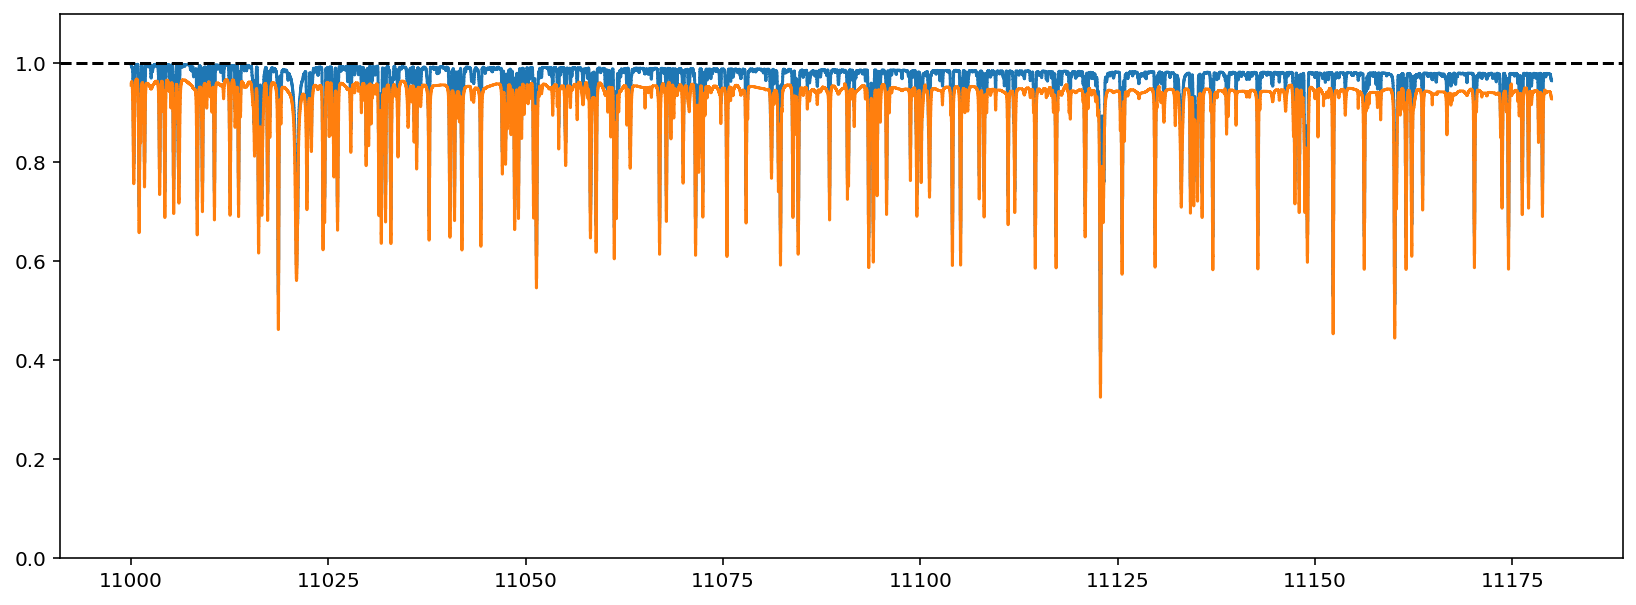

In [64]:
plt.figure(figsize=(14, 5))
plt.step(wl_active, target)
plt.axhline(1.0, color='k', linestyle='dashed')
plt.step(wl_native[sparse_emulator.active_mask], post)
plt.ylim(0.0,1.1);

In [65]:
best_fit["gp"]

{'log_amp': DeviceArray(-7.508104, dtype=float32),
 'log_diag': DeviceArray(-8.982231, dtype=float32),
 'log_scale': DeviceArray(8.733516, dtype=float32)}

In [66]:
np.exp(best_fit["gp"]["log_scale"])

6207.5137

In [67]:
resid = target - post

In [68]:
@jax.jit
def gp_predict(params):
    post = sparse_emulator.forward(params['blase']['ln_amplitudes'], 
                                   params['blase']['ln_sigma_widths'], 
                                   params['blase']['ln_gamma_widths'])
    conditional = build_gp(params["gp"]).condition(target - post).gp
    return conditional.loc

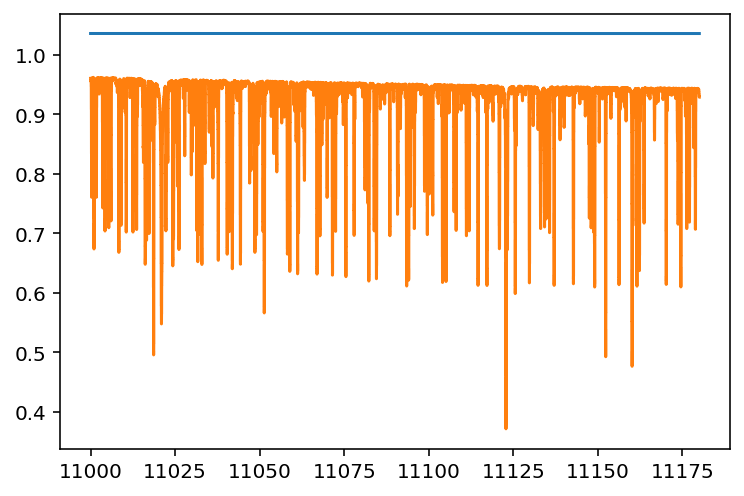

In [69]:
plt.plot(wl_active, gp_predict(best_fit) + 1)
plt.step(wl_active, target-gp_predict(best_fit))

(11000.0, 11025.0)

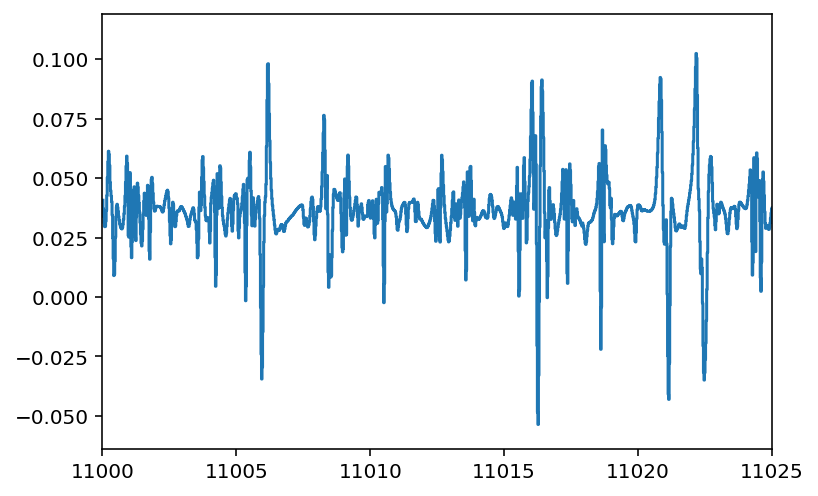

In [71]:
plt.step(wl_active, target-post)
plt.xlim(11000, 11025)

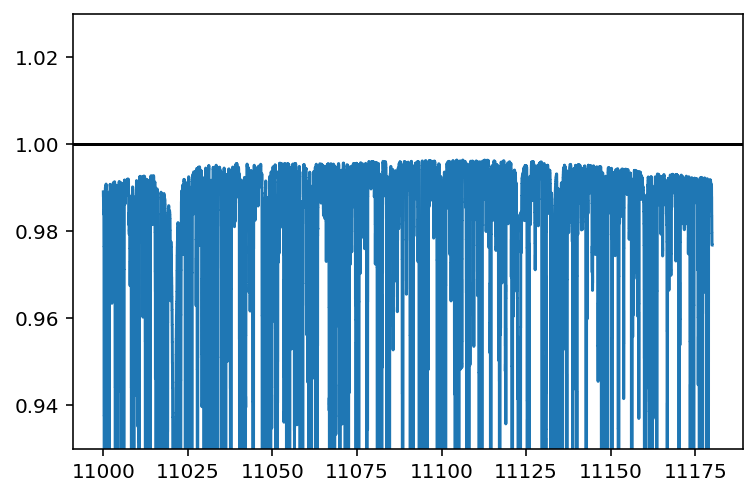

In [80]:
#plt.plot(wl_native[sparse_emulator.active_mask], gp_predict(best_fit) + 1)
plt.step(wl_active, target/(gp_predict(best_fit) + 1))
plt.ylim(0.93, 1.03)
plt.axhline(1, color='k')